In [1]:
import os
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mike219","key":"e31ce8ec560d594f9beedc32838f9fbe"}'}

In [3]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list --mine

-rw-r--r-- 1 root root 63 May  6 04:59 kaggle.json
ref                 title        size  lastUpdated          downloadCount  
------------------  -----------  ----  -------------------  -------------  
pan4sf/made-cv-hw1  made_cv_hw1  13GB  2020-04-07 14:42:37            113  
pan4sf/test-points  test_points   8MB  2020-04-11 19:37:54             97  


In [4]:
!kaggle datasets download -d pan4sf/made-cv-hw1

100% 12.6G/12.6G [05:03<00:00, 30.8MB/s]
100% 12.6G/12.6G [05:03<00:00, 44.5MB/s]


In [5]:
!kaggle datasets download -d pan4sf/test-points

 64% 5.00M/7.77M [00:00<00:00, 19.0MB/s]
100% 7.77M/7.77M [00:00<00:00, 26.0MB/s]


In [6]:
!unzip made-cv-hw1.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/images/fccc035e77798b83f53f88c0e7007f8a.jpg  
  inflating: data/train/images/fccc2bb7b78c080700f0b1775493a98e.jpg  
  inflating: data/train/images/fccc462541f48b11c6ca739f7b87b6af.jpg  
  inflating: data/train/images/fccd066771e33fff6aa3782bad026965.jpg  
  inflating: data/train/images/fccd20b40633c98b2d866b58f7148b34.jpg  
  inflating: data/train/images/fccd83743af81955ac38f3178d20fae5.jpg  
  inflating: data/train/images/fccd8d067036203d0a1ad4fca7c16b6c.jpg  
  inflating: data/train/images/fccd8f3a2377bdcd775f40e5a2a2df2d.jpg  
  inflating: data/train/images/fccd98ba65717c23a5ae98f7c64fd00a.jpg  
  inflating: data/train/images/fccdf0379d790d9c4ede93a3249eae72.jpg  
  inflating: data/train/images/fcce3cc14d9c154874ef5282b6d62775.jpg  
  inflating: data/train/images/fcce4a33a42fbfcd0059c24a09300748.jpg  
  inflating: data/train/images/fcce573f82a568a2815f4f2b827e03ba.jpg  
  inflating: data/train/images/fcce6219

In [7]:
!unzip test-points.zip

Archive:  test-points.zip
  inflating: test_points.csv         


In [0]:
!rm -rf made-cv-hw1.zip

In [0]:
!mv test_points.csv ./data/test

# Utils

In [10]:
import os

import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils import data

np.random.seed(1234)
torch.manual_seed(1234)

In [0]:
TRAIN_SIZE = 0.8
NUM_PTS = 971
# CROP_SIZE = 128
CROP_SIZE = 224
SUBMISSION_HEADER = "file_name,Point_M0_X,Point_M0_Y,Point_M1_X,Point_M1_Y,Point_M2_X,Point_M2_Y,Point_M3_X,Point_M3_Y,Point_M4_X,Point_M4_Y,Point_M5_X,Point_M5_Y,Point_M6_X,Point_M6_Y,Point_M7_X,Point_M7_Y,Point_M8_X,Point_M8_Y,Point_M9_X,Point_M9_Y,Point_M10_X,Point_M10_Y,Point_M11_X,Point_M11_Y,Point_M12_X,Point_M12_Y,Point_M13_X,Point_M13_Y,Point_M14_X,Point_M14_Y,Point_M15_X,Point_M15_Y,Point_M16_X,Point_M16_Y,Point_M17_X,Point_M17_Y,Point_M18_X,Point_M18_Y,Point_M19_X,Point_M19_Y,Point_M20_X,Point_M20_Y,Point_M21_X,Point_M21_Y,Point_M22_X,Point_M22_Y,Point_M23_X,Point_M23_Y,Point_M24_X,Point_M24_Y,Point_M25_X,Point_M25_Y,Point_M26_X,Point_M26_Y,Point_M27_X,Point_M27_Y,Point_M28_X,Point_M28_Y,Point_M29_X,Point_M29_Y\n"
TRAIN_SIZE = 0.99

In [0]:
class ScaleMaxSideToSize(object):
    def __init__(self, size=(CROP_SIZE, CROP_SIZE), elem_name='image'):
        self.size = torch.tensor(size, dtype=torch.float)
        self.elem_name = elem_name

    def __call__(self, sample):
        h, w, _ = sample[self.elem_name].shape
        if h < w:
            f = self.size[0] / w
        else:
            f = self.size[1] / h

        sample[self.elem_name] = cv2.resize(sample[self.elem_name], None, fx=f, fy=f, interpolation=cv2.INTER_AREA)
        sample["scale_coef"] = f

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2).float()
            landmarks = landmarks * f
            sample['landmarks'] = landmarks.reshape(-1)

        return sample

In [0]:
class Padding(object):
    def __init__(self, size=CROP_SIZE, elem_name='image'):
        self.size = size
        self.elem_name = elem_name

    def __call__(self, sample):
        h, w, c = sample[self.elem_name].shape
        new_image = np.zeros((self.size, self.size, c), dtype=sample[self.elem_name].dtype)
        x_padding = self.size - w
        y_padding = self.size - h
        left_padding = x_padding // 2
        right_padding = x_padding - left_padding
        top_padding = y_padding // 2
        bottom_padding = y_padding - top_padding
        new_image[top_padding:(None if bottom_padding == 0 else -bottom_padding), left_padding:(None if right_padding == 0 else -right_padding), :] = sample[self.elem_name]
        sample[self.elem_name] = new_image
        sample["padding"] = (left_padding, right_padding, top_padding, bottom_padding)
        # не хочется переписывать много кода поэтому
        sample["crop_margin_x"] = -left_padding
        sample["crop_margin_y"] = -top_padding
        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2).float()
            landmarks += torch.tensor((left_padding, top_padding), dtype=landmarks.dtype)[None, :]
            # landmarks[:, 0] = landmarks[:, 0] + left_padding
            # landmarks[:, 1] = landmarks[:, 1] + top_padding
            sample['landmarks'] = landmarks.reshape(-1)

        return sample

In [0]:
class ScaleMinSideToSize(object):
    def __init__(self, size=(CROP_SIZE, CROP_SIZE), elem_name='image'):
        self.size = torch.tensor(size, dtype=torch.float)
        self.elem_name = elem_name

    def __call__(self, sample):
        h, w, _ = sample[self.elem_name].shape
        if h > w:
            f = self.size[0] / w
        else:
            f = self.size[1] / h

        sample[self.elem_name] = cv2.resize(sample[self.elem_name], None, fx=f, fy=f, interpolation=cv2.INTER_AREA)
        sample["scale_coef"] = f

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2).float()
            landmarks = landmarks * f
            sample['landmarks'] = landmarks.reshape(-1)

        return sample

In [0]:
class CropCenter(object):
    def __init__(self, size=CROP_SIZE, elem_name='image'):
        self.size = size
        self.elem_name = elem_name

    def __call__(self, sample):
        img = sample[self.elem_name]
        h, w, _ = img.shape
        margin_h = (h - self.size) // 2
        margin_w = (w - self.size) // 2
        sample[self.elem_name] = img[margin_h:margin_h + self.size, margin_w:margin_w + self.size]
        sample["crop_margin_x"] = margin_w
        sample["crop_margin_y"] = margin_h

        if 'landmarks' in sample:
            landmarks = sample['landmarks'].reshape(-1, 2)
            landmarks -= torch.tensor((margin_w, margin_h), dtype=landmarks.dtype)[None, :]
            sample['landmarks'] = landmarks.reshape(-1)

        return sample

In [0]:
class TransformByKeys(object):
    def __init__(self, transform, names):
        self.transform = transform
        self.names = set(names)

    def __call__(self, sample):
        for name in self.names:
            if name in sample:
                sample[name] = self.transform(sample[name])

        return sample

In [0]:
class ThousandLandmarksDataset(data.Dataset):
    def __init__(self, root, transforms, split="train"):
        super(ThousandLandmarksDataset, self).__init__()
        self.root = root
        landmark_file_name = os.path.join(root, 'landmarks.csv') if split is not "test" \
            else os.path.join(root, "test_points.csv")
        images_root = os.path.join(root, "images")

        df = pd.read_csv(landmark_file_name, delimiter='\t')

        self.landmarks = []
        self.image_names = []

        split_idxs = {"train": range(0, int(TRAIN_SIZE * len(df))),
                      "val": range(int(TRAIN_SIZE * len(df)), len(df)),
                      "test": range(len(df))}
        idxs = split_idxs[split]

        if split in ("train", "val"):
            for row in df._values[idxs]:
                self.image_names.append(os.path.join(images_root, row[0]))
                self.landmarks.append(row[1:].astype('int32').reshape((len(row) // 2, 2)))
            self.landmarks = torch.as_tensor(self.landmarks)
        elif split == 'test':
            for row in df._values[idxs]:
                self.image_names.append(os.path.join(images_root, row[0]))
            self.landmarks = None
        else:
            raise NotImplementedError(split)

        self.transforms = transforms

    def __getitem__(self, idx):
        while True:
            sample = {}
            if self.landmarks is not None:
                landmarks = self.landmarks[idx]
                sample["landmarks"] = landmarks

            image = cv2.imread(self.image_names[idx])
            if image is None:
                idx = np.random.randint(0, len(self.image_names))
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            sample["image"] = image

            if self.transforms is not None:
                sample = self.transforms(sample)

            return sample

    def __len__(self):
        return len(self.image_names)

In [0]:
def restore_landmarks(landmarks, f, margins):
    dx, dy = margins
    landmarks[:, 0] += dx
    landmarks[:, 1] += dy
    landmarks /= f
    return landmarks


def restore_landmarks_batch(landmarks, fs, margins_x, margins_y):
    landmarks[:, :, 0] += margins_x[:, None]
    landmarks[:, :, 1] += margins_y[:, None]
    landmarks /= fs[:, None, None]
    return landmarks

In [0]:
def create_submission(path_to_data, test_predictions, path_to_submission_file):
    test_dir = os.path.join(path_to_data, "test")

    output_file = path_to_submission_file
    wf = open(output_file, 'w')
    wf.write(SUBMISSION_HEADER)

    mapping_path = os.path.join(test_dir, 'test_points.csv')
    mapping = pd.read_csv(mapping_path, delimiter='\t')

    for i, row in mapping.iterrows():
        file_name = row[0]
        point_index_list = np.array(eval(row[1]))
        points_for_image = test_predictions[i]
        needed_points = points_for_image[point_index_list].astype(np.int)
        wf.write(file_name + ',' + ','.join(map(str, needed_points.reshape(2 * len(point_index_list)))) + '\n')

# Обучение

In [0]:
import os
import pickle
import sys
from argparse import ArgumentParser

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms


torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
class Args():
    pass

args = Args()
args.name = "coord_conv_resnet_152_new_fix"
args.data = "./data"
args.batch_size = 256
args.epochs = 4
args.learning_rate = 5e-4
args.gpu = True

In [0]:
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="training..."):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks)
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(train_loss)

In [0]:
def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in tqdm.tqdm(loader, total=len(loader), desc="validation..."):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks)
        val_loss.append(loss.item())

    return np.mean(val_loss)

In [0]:
def predict(model, loader, device):
    model.eval()
    predictions = np.zeros((len(loader.dataset), NUM_PTS, 2))
    for i, batch in enumerate(tqdm.tqdm(loader, total=len(loader), desc="test prediction...")):
        images = batch["image"].to(device)

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        pred_landmarks = pred_landmarks.numpy().reshape((len(pred_landmarks), NUM_PTS, 2))  # B x NUM_PTS x 2

        fs = batch["scale_coef"].numpy()  # B
        margins_x = batch["crop_margin_x"].numpy()  # B
        margins_y = batch["crop_margin_y"].numpy()  # B
        prediction = restore_landmarks_batch(pred_landmarks, fs, margins_x, margins_y)  # B x NUM_PTS x 2
        predictions[i * loader.batch_size: (i + 1) * loader.batch_size] = prediction

    return predictions

In [0]:
 train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    # ScaleMaxSideToSize((CROP_SIZE, CROP_SIZE)),  # ошибки
    # Padding(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ("image",)),
])

In [26]:
print("Reading data...")
train_dataset = ThousandLandmarksDataset(os.path.join(args.data, 'train'), train_transforms, split="train")
train_dataloader = data.DataLoader(train_dataset, batch_size=args.batch_size, num_workers=4, pin_memory=True,
                                    shuffle=True, drop_last=True)

Reading data...


In [0]:
val_dataset = ThousandLandmarksDataset(os.path.join(args.data, 'train'), train_transforms, split="val")
val_dataloader = data.DataLoader(val_dataset, batch_size=args.batch_size, num_workers=4, pin_memory=True,
                                    shuffle=False, drop_last=False)

# ResNet

In [0]:
import torch
import torch.nn as nn
from torchvision.models.utils import load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        
        self.out_channels = 512 * block.expansion
        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # x = self.avgpool(x)
        # x = torch.flatten(x, 1)
        # x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)



def resnet34(pretrained=False, progress=True, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)



def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)



def resnet101(pretrained=False, progress=True, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)



def resnet152(pretrained=False, progress=True, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)

# CoordConv

In [0]:
import torch
import torch.nn as nn


class AddCoordsTh(nn.Module):
    def __init__(self, x_dim=64, y_dim=64, with_r=False):
        super(AddCoordsTh, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.with_r = with_r

    def forward(self, input_tensor):
        """
        input_tensor: (batch, c, x_dim, y_dim)
        """
        batch_size_tensor = input_tensor.shape[0]

        xx_ones = torch.ones([1, self.y_dim], dtype=torch.int32)
        xx_ones = xx_ones.unsqueeze(-1)

        xx_range = torch.arange(self.x_dim, dtype=torch.int32).unsqueeze(0)
        xx_range = xx_range.unsqueeze(1)

        xx_channel = torch.matmul(xx_ones, xx_range)
        xx_channel = xx_channel.unsqueeze(-1)

        yy_ones = torch.ones([1, self.x_dim], dtype=torch.int32)
        yy_ones = yy_ones.unsqueeze(1)

        yy_range = torch.arange(self.y_dim, dtype=torch.int32).unsqueeze(0)
        yy_range = yy_range.unsqueeze(-1)

        yy_channel = torch.matmul(yy_range, yy_ones)
        yy_channel = yy_channel.unsqueeze(-1)

        xx_channel = xx_channel.permute(0, 3, 2, 1)
        yy_channel = yy_channel.permute(0, 3, 2, 1)

        xx_channel = xx_channel.float() / (self.x_dim - 1)
        yy_channel = yy_channel.float() / (self.y_dim - 1)

        xx_channel = xx_channel * 2 - 1
        yy_channel = yy_channel * 2 - 1

        xx_channel = xx_channel.repeat(batch_size_tensor, 1, 1, 1)
        yy_channel = yy_channel.repeat(batch_size_tensor, 1, 1, 1)

        ret = torch.cat([input_tensor, xx_channel, yy_channel], dim=1)

        if self.with_r:
            rr = torch.sqrt(torch.pow(xx_channel - 0.5, 2) + torch.pow(yy_channel - 0.5, 2))
            ret = torch.cat([ret, rr], dim=1)

        return ret


class CoordConvTh(nn.Module):
    """CoordConv layer as in the paper."""
    def __init__(self, x_dim, y_dim, with_r, *args, **kwargs):
        super(CoordConvTh, self).__init__()
        self.addcoords = AddCoordsTh(x_dim=x_dim, y_dim=y_dim, with_r=with_r)
        self.conv = nn.Conv2d(*args, **kwargs)

    def forward(self, input_tensor):
        ret = self.addcoords(input_tensor)
        ret = self.conv(ret)
        return ret


'''
An alternative implementation for PyTorch with auto-infering the x-y dimensions.
'''
class AddCoords(nn.Module):

    def __init__(self, with_r=False):
        super().__init__()
        self.with_r = with_r

    def forward(self, input_tensor):
        """
        Args:
            input_tensor: shape(batch, channel, x_dim, y_dim)
        """
        batch_size, _, x_dim, y_dim = input_tensor.size()

        xx_channel = torch.arange(x_dim).repeat(1, y_dim, 1)
        yy_channel = torch.arange(y_dim).repeat(1, x_dim, 1).transpose(1, 2)

        xx_channel = xx_channel.float() / (x_dim - 1)
        yy_channel = yy_channel.float() / (y_dim - 1)

        xx_channel = xx_channel * 2 - 1
        yy_channel = yy_channel * 2 - 1

        xx_channel = xx_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3)
        yy_channel = yy_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3)

        ret = torch.cat([
            input_tensor,
            xx_channel.type_as(input_tensor),
            yy_channel.type_as(input_tensor)], dim=1)

        if self.with_r:
            rr = torch.sqrt(torch.pow(xx_channel.type_as(input_tensor) - 0.5, 2) + torch.pow(yy_channel.type_as(input_tensor) - 0.5, 2))
            ret = torch.cat([ret, rr], dim=1)

        return ret


class CoordConv(nn.Module):

    def __init__(self, in_channels, out_channels, with_r=False, **kwargs):
        super().__init__()
        self.addcoords = AddCoords(with_r=with_r)
        in_size = in_channels+2
        if with_r:
            in_size += 1
        self.conv = nn.Conv2d(in_size, out_channels, **kwargs)

    def forward(self, x):
        ret = self.addcoords(x)
        ret = self.conv(ret)
        return ret

# Model

In [0]:
class CustomModel(nn.Module):

    def __init__(self, num_classes=(2*NUM_PTS)):
        super().__init__()
        self.backbone = resnet152(pretrained=False)
        # надо разморозить только layer 4, чтобы поместиться в память
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.backbone.layer4.parameters():
            param.requires_grad = True
        # coord conv
        self.coordconv1 = CoordConv(self.backbone.out_channels, num_classes, True, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_classes)
        self.relu1 = nn.ReLU(inplace=True)

        self.coordconv2 = CoordConv(num_classes, num_classes, True, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(num_classes)
        self.relu2 = nn.ReLU(inplace=True)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_classes, num_classes)

        # init weights
        torch.nn.init.xavier_uniform(self.coordconv1.conv.weight)
        self.coordconv1.conv.bias.data.fill_(0.01)
        torch.nn.init.xavier_uniform(self.coordconv2.conv.weight)
        self.coordconv2.conv.bias.data.fill_(0.01)
        torch.nn.init.xavier_uniform(self.fc.weight)
        self.fc.bias.data.fill_(0.01)

    def forward(self, x):
        x = self.backbone(x)
        x = self.relu1(self.bn1(self.coordconv1(x)))
        x = self.relu2(self.bn2(self.coordconv2(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [0]:
drive_path = './drive/My Drive/MADE/CV/faces/model'

In [31]:
print("Creating model...")
device = torch.device("cuda: 0") if args.gpu else torch.device("cpu")
model = CustomModel(2 * NUM_PTS)
load = True
if load:
    with open(f"{drive_path}/{args.name}_best.pth", "rb") as fp:
        best_state_dict = torch.load(fp, map_location="cpu")
        model.load_state_dict(best_state_dict)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, amsgrad=True, weight_decay=1e-5)
loss_fn = fnn.mse_loss
# loss_fn = torch.nn.SmoothL1Loss()  # возможно критическая ошибка
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8, last_epoch=-1)

Creating model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [32]:
model

CustomModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [0]:
from glob import glob

In [0]:
files = glob('./data/test/images/*')

In [44]:
files[:10]

['./data/test/images/0315753fb6b587969f31f3026d596131.jpg',
 './data/test/images/365319c77e1d741c73962c90a1c3edc8.jpg',
 './data/test/images/447e428a0f980fd0aed369918d5c7a7f.jpg',
 './data/test/images/d5c2beed19963449bd9f6794113d277c.jpg',
 './data/test/images/c6576cce0a106fb7d2929f8426fe6255.jpg',
 './data/test/images/5209a2d0f8931dec6f2a755126893b5e.jpg',
 './data/test/images/9492284cb09527fe0ff345911c94ba79.jpg',
 './data/test/images/709aff93c699bfe6fe0a31333d3f29d4.jpg',
 './data/test/images/c43783f653e2f790db341504983bebfe.jpg',
 './data/test/images/f85cad14f66dce041e862a921d9ca746.jpg']

In [0]:
import cv2
from PIL import Image

def load_image(image_name):
    img = cv2.imread(image_name)
    return img

In [56]:
img = load_image(files[0])
img.shape

(396, 274, 3)

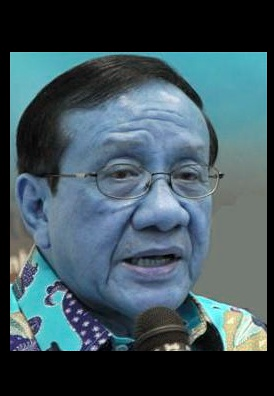

In [49]:
Image.fromarray(img)

# Идеи

CoordConv2D



In [0]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [0]:
 # 2. train & validate
print("Ready for training...")
best_val_loss = np.inf
for epoch in range(args.epochs):
    train_loss = train(model, train_dataloader, loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, loss_fn, device=device)
    print("Epoch #{:2}:\t lr: {} train loss: {:5.2}\tval loss: {:5.2}".format(get_lr(optimizer), epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(f"{drive_path}/{args.name}_best.pth", "wb") as fp:
            torch.save(model.state_dict(), fp)
    scheduler.step()


training...:   0%|          | 0/1523 [00:00<?, ?it/s]

Ready for training...



training...: 100%|██████████| 1523/1523 [2:52:55<00:00,  6.81s/it]

validation...: 100%|██████████| 16/16 [01:19<00:00,  4.98s/it]


Epoch #0.0005:	 lr: 0 train loss: 6.1e+01	val loss: 5.5e+01



training...: 100%|██████████| 1523/1523 [2:52:44<00:00,  6.81s/it]

validation...: 100%|██████████| 16/16 [01:22<00:00,  5.13s/it]


Epoch #0.0004:	 lr: 1 train loss: 5.3e+01	val loss: 5.1e+01



training...: 100%|██████████| 1523/1523 [2:53:37<00:00,  6.84s/it]

validation...: 100%|██████████| 16/16 [01:20<00:00,  5.02s/it]


Epoch #0.00032:	 lr: 2 train loss: 4.8e+01	val loss: 4.5e+01



training...:  24%|██▍       | 365/1523 [41:57<2:11:52,  6.83s/it]

In [0]:
 # 3. predict
test_dataset = ThousandLandmarksDataset(os.path.join(args.data, 'test'), train_transforms, split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=args.batch_size, num_workers=4, pin_memory=True,
                                    shuffle=False, drop_last=False)

In [35]:
with open(f"{drive_path}/{args.name}_best.pth", "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

test_predictions = predict(model, test_dataloader, device)
with open(f"{drive_path}/{args.name}_test_predictions.pkl", "wb") as fp:
    pickle.dump({"image_names": test_dataset.image_names,
                    "landmarks": test_predictions}, fp)

create_submission(args.data, test_predictions, f"{drive_path}/{args.name}_submit.csv")

test prediction...: 100%|██████████| 390/390 [32:27<00:00,  4.99s/it]


# Визуализация

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

np.random.seed(1234)

In [0]:
TEST_PREDICTIONS_FILENAME = f"{drive_path}/{args.name}_test_predictions.pkl"
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [0]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [8]:
with open(TEST_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

if len(image_names) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(image_names)}")

Images: 99819
Landmarks shape: (99819, 971, 2)


TypeError: ignored

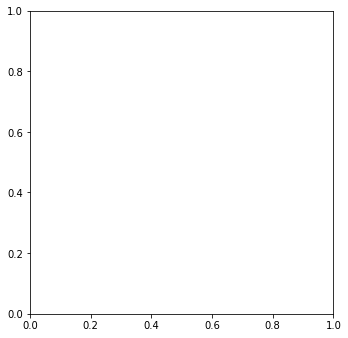

In [10]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()

In [0]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()